In [5]:
import os
import re
import json
import shutil
import re
import logging
from math import radians, cos, sin, asin, sqrt

In [6]:
import pandas as pd
# from tqdm import tqdm
import numpy as np
import math

from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold

import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [7]:
!pip install geopandas
!pip install descartes
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


# 读取数据
- 读取清洗过的事件和码头数据

In [9]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = 'train0714.csv'
test_data_path = 'R2_ATest0711.csv'
order_data_path = 'loadingevents.csv'
port_data_path = 'port_fixed_0612.csv'

In [10]:
def get_data(data, mode = 'train'):
    assert mode=='train' or mode=='test'
    
    # data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    data["TRANSPORT_TRACE"] = data['TRANSPORT_TRACE'].astype(str)
    # data["Start"] = data["TRANSPORT_TRACE"].apply(lambda x: x.split("-")[0])
    if mode=='train':
        data['vesselNextportETA'] = pd.to_datetime(data['vesselNextportETA'], infer_datetime_format=True)
        # data["End"] = data["TRANSPORT_TRACE"].apply(lambda x: x.split("-")[-1])
        # data['StartEnd'] = data['Start'].values+'-'+data["End"].values
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)

    print('========== Finish Collecting Data ==========')
    return data

## 读取测试集

In [8]:
# baseline只用到gps定位数据，即train_gps_path
train_gps_path = 'train0714.csv'
test_data_path = 'R2_ATest0711.csv'
order_data_path = 'loadingevents.csv'
port_data_path = 'port_fixed_0612.csv'

In [11]:
test_data = pd.read_csv('/home/ma-user/work/FuSai/data/'+test_data_path)
course_list = list(sorted(test_data["TRANSPORT_TRACE"].unique()))
test_data["Port_list"] = test_data["TRANSPORT_TRACE"].apply(lambda x: x.split("-"))
start_list = test_data["TRANSPORT_TRACE"].apply(lambda x: x.split("-")[0])
port_lists = np.unique(test_data["Port_list"])
test_data = get_data(test_data, mode='test')

========== Finish Collecting Data ==========


In [12]:
course_list

['BRSSZ-CNSHK',
 'BRSSZ-HKHKG',
 'CNDCB-SGSIN',
 'CNHKG-ARBUE',
 'CNHKG-GTPRQ',
 'CNHKG-MXZLO',
 'CNHKG-RUVVO',
 'CNNSA-CMKBI',
 'CNNSA-GHTEM',
 'CNNSA-MYTPP-SGSIN-ZACPT-CGPNR-GALBV-CMKBI',
 'CNNSA-NAWVB',
 'CNNSA-SGSIN-AEJEA',
 'CNNSA-SGSIN-MYTPP-NAWVB-CGPNR-NGAPP',
 'CNNSA-SGSIN-MYTPP-TGLFW-GHTEM',
 'CNSHA-PAMIT',
 'CNSHK-BDCGP',
 'CNSHK-BHBAH',
 'CNSHK-BRSSZ',
 'CNSHK-CLSAI',
 'CNSHK-CLSAN',
 'CNSHK-CLVAP',
 'CNSHK-CNNSA-MYTPP-SGSIN-BJCOO-CIABJ',
 'CNSHK-EGPSD',
 'CNSHK-ESALG',
 'CNSHK-ESVAL',
 'CNSHK-GRPIR',
 'CNSHK-GRPIR-ITSPE-ITGOA',
 'CNSHK-HKHKG-CNNBG-CNSHA-MXZLO-MXLZC-GTPRQ',
 'CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZLO-PABLB-PAMIT-COCTG-JMKIN-DOCAU',
 'CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZLO-PABLB-PAMIT-COCTG-JMKIN-DOHAI-ANPHI-GPPTP-TTPOS',
 'CNSHK-IDJKT',
 'CNSHK-INMAA',
 'CNSHK-INMUN',
 'CNSHK-INNSA',
 'CNSHK-INNSA-LKCMB-AEJEA-AEAUH-KWKWI',
 'CNSHK-JPHKT',
 'CNSHK-JPTYO',
 'CNSHK-KHKOS',
 'CNSHK-KRINC',
 'CNSHK-LBBEY',
 'CNSHK-LKCMB',
 'CNSHK-MXZLO',
 'CNSHK-MY

In [25]:
from sklearn.cluster import DBSCAN
DBSCAN(eps=0.5,  # 邻域半径
min_samples=2,    # 最小样本点数，MinPts
metric='euclidean',
metric_params=None,
algorithm='auto', # 'auto','ball_tree','kd_tree','brute',4个可选的参数 寻找最近邻点的算法，例如直接密度可达的点
leaf_size=30, # balltree,cdtree的参数
p=None, # 
n_jobs=1)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=10, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

In [4]:
df_port = pd.read_csv('/home/ma-user/work/FuSai/data/'+port_data_path)
x = df_port[['LONGITUDE','LATITUDE']].values
y_pred = DBSCAN().fit_predict(x)
df_port['cluster'] = y_pred
# df_port = df_port.drop_duplicates(subset = ['TRANSPORT_NODE_ID'],keep = 'first')
# df_port = df_port.drop_duplicates(subset = ['TRANS_NODE_NAME'],keep = 'first')
# df_port.to_csv('/home/ma-user/work/FuSai/data/port_fixed_0721.csv',index=False)

NameError: name 'pd' is not defined

In [16]:
df_port_short = df_port[df_port['TRANS_NODE_NAME'].isin(port_list)]
# df_port_short = df_port_short.drop_duplicates(subset = ['TRANSPORT_NODE_ID'],keep = 'first')
# df_port_short = df_port_short.drop_duplicates(subset = ['TRANS_NODE_NAME'],keep = 'first')
df_port_short.to_csv('/home/ma-user/work/FuSai/data/port_R2ATest.csv',index=False)

In [1]:
port_list = []
for i in range(len(np.unique(test_data['Port_list'].values))):
    port_list.extend(np.unique(test_data['Port_list'].values)[i])

NameError: name 'np' is not defined

In [17]:
fig = plt.figure()
fig = world.plot(figsize = (10,10))
fig.scatter(df_port_short['LONGITUDE'],df_port_short['LATITUDE'],s=1, c = df_port_short['cluster'],cmap = 'jet')
# fig.scatter(train_port['longitude'].mean(),train_port['latitude'].mean(),color='r',s=5)
# fig.set_xlim([train_port['longitude'].mean()-5,train_port['longitude'].mean()+5])
# fig.set_ylim([train_port['latitude'].mean()-5,train_port['latitude'].mean()+5])
fig.set_xlim([105,130])
fig.set_ylim([15,45])

NameError: name 'world' is not defined

In [ ]:
os.chdir('/home/ma-user/work/FuSai/data/order/')
train_orders = sorted(glob.glob('*.csv'))
all_orders = pd.DataFrame(columns = ['Min_Time','Min_Long','Min_Lat','Max_Time','Max_Long','Max_Lat','Max_Speed','loadingOrder','day_diff','TRANSPORT_TRACE','course_number'])
for i in range(len(train_orders)):
    train_data = pd.read_csv(train_orders[i], names = column_list)
    train_data.sort_values(by = 'timestamp')
    dt = (pd.to_datetime(train_data['timestamp'].iloc[-1]) - pd.to_datetime(train_data['timestamp'])).iloc[0]
    dt = dt.total_seconds()/3600/24
    all_orders.loc[i] = [train_data['timestamp'].iloc[0], train_data['longitude'].iloc[0], train_data['latitude'].iloc[0],\
             train_data['timestamp'].iloc[-1], train_data['longitude'].iloc[-1], train_data['latitude'].iloc[-1], train_data['speed'].max(),\
             train_data['loadingOrder'].unique()[0],dt,train_data['TRANSPORT_TRACE'].unique()[0],np.nan]
    all_orders = all_orders[(all_orders['Max_Speed'] <= 50.) & (all_orders['day_diff'] >= 4.)]
    if (i + 1) % 22 == 0:
        print('Finish ',(i+1) * 100 / len(train_orders),' % of orders.')
all_orders.to_csv('/home/ma-user/work/FuSai/data/routes/all_routes.csv',index = False)

## 清洗数据

In [19]:
def geodistance(x,lng1,lat1,lng2,lat2):
    #lng1,lat1,lng2,lat2 = (120.12802999999997,30.28708,115.86572000000001,28.7427)
    lng1, lat1, lng2, lat2 = map(radians, [float(x[lng1]), float(x[lat1]), float(x[lng2]), float(x[lat2])]) # 经纬度转换成弧度
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance=2*asin(sqrt(a))*6371*1000 # 地球平均半径，6371km # unit: m
    distance=round(distance/1000,3) # unit: km
    return distance

def split_ports(x,i):
    try:
        res=re.split(r'[>-]',x)[i]
        return res
    except Exception as e:
        return ""

In [20]:
all_orders = pd.read_csv('/home/ma-user/work/FuSai/data/route_set/all_routes.csv')
train_orders = all_orders["loadingOrder"].unique()
df_port_short = pd.read_csv('/home/ma-user/work/FuSai/data/port_R2ATest.csv')
train_gps_path = '/home/ma-user/work/FuSai/data/order/'
column_list = ['loadingOrder','timestamp','longitude','latitude','speed','direction','vesselNextport','TRANSPORT_TRACE']

In [23]:
def get_new_old(ind,size):
    now = np.zeros((len(ind),5),dtype = int)
    now[:,0] = 0
    now[:,2] = ind
    now[:,1] = now[:,2]-1
    now[:,3] = now[:,2]+1
    now[:,4] = size-1
    new = np.min(now[:,3::],axis=1)
    old = np.max(now[:,0:2],axis=1)
    return new,now[:,2],old

def process_velocity(train_df):    
    lon = train_df['longitude'].values
    lat = train_df['latitude'].values
    speed = train_df['speed'].values
    direction = train_df['direction'].values
    ind = np.where((direction <= 0.)|(speed == 0.))
    train_df["time_used"]=pd.to_datetime(train_df["timestamp"])-pd.to_datetime(train_df["timestamp"].iloc[0])
    train_df["time_used"]=train_df["time_used"].dt.total_seconds()
    time = train_df["time_used"].values
    new,now,old = get_new_old(np.arange(train_df.shape[0]),train_df.shape[0])
    londiff = lon[new] - lon[old]
    londiff[londiff > 350] = londiff[londiff > 350] - 360
    londiff[londiff < -350] = londiff[londiff < -350] + 360
    print('londiff.max = ',max(londiff))
    dx = np.cos(lat[now]*np.pi/180)*londiff
    dy = (lat[new] - lat[old])
    train_df['ds'] = 0.5*111.111*(dx**2+dy**2)**0.5
    print('ind = ',len(ind[0]),', total_ds =',train_df['ds'].sum())
    if (len(ind[0]) >= 0):
        dir_new, dir_now, dir_old = get_new_old(now[ind],train_df.shape[0])
        speed[dir_now] = np.round(3600*111.111*(dx[dir_now]**2+dy[dir_now]**2)**0.5/(time[dir_new]-time[dir_old]),0)
        # print('speed =',speed[dir_now])
        train_df['speed'] = speed
        direction[dir_now] = np.round(np.arctan2(dx[dir_now],dy[dir_now])*18000/np.pi,0)
        direction[direction < 0] = direction[direction < 0] + 36000.
        train_df['direction'] = direction

    return train_df

def cluster_stop_ports(train_df):
    train_start = train_df.iloc[0:5,:]
    train_end = train_df.iloc[-5::,:]
    train_stop = train_df[(train_df['speed']<=1) & (train_df['direction']>=0.)]
    train_stop = pd.concat([train_start,train_stop,train_end])
    train_stop = train_stop.drop_duplicates(keep = 'first')
    train_stop = train_stop.sort_values(by=['timestamp'],ascending=[True])
    index = np.array(train_stop.index)
    x = train_stop[['longitude','latitude']].values
    y_pred = DBSCAN().fit_predict(x)
    train_stop['port'] = y_pred
    if train_stop['port'].min() == -1:
        ind = np.where(train_stop['port'].unique() == -1)[0][0]
        # print('ind where (y_pred == -1) is:',ind)
        ys = np.unique(y_pred)
        train_stop['port'][train_stop['port'].isin(list(ys[(ind+1)::]))] = train_stop['port'][train_stop['port'].isin(list(ys[(ind+1)::]))]+1
        train_stop['port'][train_stop['port'] == -1] = ind
    # print(train_stop['port'].unique())
    return train_stop, index

def generate_port_stops(train_stop):
    ttc = []
    for j in range(len(train_stop['port'].unique())):
        part = train_stop[train_stop['port'] == train_stop['port'].unique()[j]]
        df_port_short['target_longitude'] = part['longitude'].mean()
        df_port_short['target_latitude'] = part['latitude'].mean()
        df_port_short['distance'] = df_port_short.apply(lambda x:geodistance(x,"LONGITUDE","LATITUDE","target_longitude","target_latitude"),axis=1)
        if df_port_short['distance'].min() > 33.3333:
            ttc.append('GHOST'+str(j))
        else:
            ttc.append(df_port_short[df_port_short['distance'] == df_port_short['distance'].min()]['TRANS_NODE_NAME'].unique()[0])
        print(df_port_short['distance'].min(),'km away from the nearest port:',ttc[-1])
    return ttc

def generate_vesselCurrentport(train_df):
    train_stop, index = cluster_stop_ports(train_df)
    ttc = generate_port_stops(train_stop)
        
    vesselCurrentport = np.nan*np.zeros((train_df.shape[0],),dtype=object)
    cnt = 0
    for k in index:
        vesselCurrentport[k] = ttc[train_stop['port'].values[cnt]]
        cnt += 1
    train_df['vesselCurrentport'] = vesselCurrentport
    if (len(ttc) >= 2) and (len(train_df['vesselCurrentport'].unique())>=3):
        index_min = train_df[train_df['vesselCurrentport'].isin(ttc)].index.min()
        train_df = train_df[train_df.index>=index_min]
        train_df.index = np.arange(len(train_df))
        train_df['time_used'] = train_df['time_used'] - train_df['time_used'].min()
        index_max = train_df[train_df['vesselCurrentport'].isin(ttc)].index.max()
        train_df = train_df[train_df.index<=index_max]
    names_col = ['loadingOrder','timestamp','longitude','latitude','ds','speed','direction','vesselCurrentport','vesselNextport',\
                 'TRANSPORT_TRACE','time_used']

    return train_df[names_col],ttc

def order_process(train_gps_path,train_orders):
    for i in range(len(train_orders)):
        column_list = ['loadingOrder','timestamp','longitude','latitude','speed','direction','vesselNextport','TRANSPORT_TRACE']
        print('processing the order =',train_orders[i],',i =',i)
        train_df = pd.read_csv(train_gps_path+train_orders[i]+'.csv', names = column_list)
        train_df = train_df.drop_duplicates(keep='first')
        train_df = train_df.sort_values(by=['timestamp'],ascending=[True])
        train_df.index = np.arange(len(train_df))
        # 第一步：清洗不正常的速率和方向
        train_df = process_velocity(train_df)
        # 第二步: 找到这个运单号停船的行数
        train_stop, index = cluster_stop_ports(train_df)
        train_df,ttc = generate_vesselCurrentport(train_df)
        train_df.to_csv('/home/ma-user/work/FuSai/data/orderp/'+train_orders[i]+'.csv',header=None,index=False)

In [24]:
order_process(train_gps_path,train_orders)

processing the order = AA191175561416 ,i = 0
londiff.max =  2.785525000000007
ind =  1378 , total_ds = 15081.994278131566
1.683 km away from the nearest port: CNYTN
13.161 km away from the nearest port: TWKHH
79.827 km away from the nearest port: GHOST2
66.188 km away from the nearest port: GHOST3
0.638 km away from the nearest port: CNNBG
13.173 km away from the nearest port: MXZLO
processing the order = AA236935066990 ,i = 1
londiff.max =  0.5538669999999986
ind =  128 , total_ds = 18283.457429640057
8.935 km away from the nearest port: CNDCB
6.299 km away from the nearest port: MYTPP
11.795 km away from the nearest port: EGSUZ
32.988 km away from the nearest port: RTM
processing the order = AA500472614535 ,i = 2
londiff.max =  0.5601740000000461
ind =  0 , total_ds = 4323.866613883527
2507.849 km away from the nearest port: GHOST0
824.265 km away from the nearest port: GHOST1
processing the order = AA597788695392 ,i = 3
londiff.max =  0.5885219999999975
ind =  82 , total_ds = 9792.2

processing the order = AC498331004901 ,i = 28
londiff.max =  4.112947999999989
ind =  482 , total_ds = 3600.542087358257
9.838 km away from the nearest port: CNDCB
3.034 km away from the nearest port: THLCH
97.509 km away from the nearest port: GHOST2
processing the order = AC503876981958 ,i = 29
londiff.max =  0.23712000000000444
ind =  45 , total_ds = 3356.715286611088
19.076 km away from the nearest port: HON
5.298 km away from the nearest port: IDJKT
processing the order = AC513854053622 ,i = 30
londiff.max =  0.7555410000000009
ind =  389 , total_ds = 18352.530809662003
1.529 km away from the nearest port: CNYTN
7.532 km away from the nearest port: LKCMB
11.93 km away from the nearest port: EGSUZ
27.707 km away from the nearest port: RTM
processing the order = AC552370744460 ,i = 31
londiff.max =  0.06235500000000016
ind =  215 , total_ds = 15753.512403717335
7.867 km away from the nearest port: CNDCB
347.469 km away from the nearest port: GHOST1
6.164 km away from the nearest por

londiff.max =  0.18491000000000213
ind =  830 , total_ds = 11961.662149918782
13.645 km away from the nearest port: HON
15.575 km away from the nearest port: SGSIN
12.452 km away from the nearest port: MYPKG
20.051 km away from the nearest port: ZADUR
processing the order = AE105181004450 ,i = 57
londiff.max =  3.170872000000003
ind =  253 , total_ds = 9728.790428537894
1.814 km away from the nearest port: CNHKG
639.095 km away from the nearest port: GHOST1
0.189 km away from the nearest port: NZAKL
processing the order = AE142660185850 ,i = 58
londiff.max =  0.057800000000000296
ind =  15012 , total_ds = 11063.874092031105
2.672 km away from the nearest port: CNYTN
5.162 km away from the nearest port: MYTPP
1299.45 km away from the nearest port: GHOST2
971.439 km away from the nearest port: GHOST3
processing the order = AE148726098347 ,i = 59
londiff.max =  0.2743899999999968
ind =  419 , total_ds = 12530.993360047127
9.41 km away from the nearest port: CNDCB
5.532 km away from the ne

KeyboardInterrupt: 

In [50]:
test_data = pd.read_csv('/home/ma-user/work/FuSai/data/'+test_data_path)
course_list = list(sorted(test_data["TRANSPORT_TRACE"].unique()))
test_data = get_data(test_data, mode='test')
test_orders = test_data['loadingOrder'].unique()

========== Finish Collecting Data ==========


In [40]:
test_data["time_used"]=pd.to_datetime(test_data["timestamp"])-pd.to_datetime(list(test_data["onboardDate"]),utc=True)
test_data["time_used"]=test_data["time_used"].dt.total_seconds()

In [42]:
test_df = test_data[test_data['loadingOrder'] == test_orders[0]]
test_df

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,time_used
0,QM149151037282,2019-01-11T04:18:28.000Z,114.337167,22.556333,28.0,10680.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T04:18:28.000Z,0.0
1,QM149151037282,2019-01-11T04:39:08.000Z,114.426632,22.508475,30.0,13140.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T04:39:08.000Z,1240.0
2,QM149151037282,2019-01-11T06:05:48.000Z,114.418000,22.182000,27.0,22210.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T06:05:48.000Z,6440.0
3,QM149151037282,2019-01-11T08:48:28.000Z,114.101650,22.314968,15.0,4420.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T08:48:28.000Z,16200.0
4,QM149151037282,2019-01-11T09:50:58.000Z,114.123500,22.324167,0.0,7310.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T09:50:58.000Z,19950.0
5,QM149151037282,2019-01-11T09:56:58.000Z,114.123500,22.324167,0.0,7380.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T09:56:58.000Z,20310.0
6,QM149151037282,2019-01-11T10:11:58.000Z,114.123478,22.324248,0.0,7510.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T10:11:58.000Z,21210.0
7,QM149151037282,2019-01-11T10:26:58.000Z,114.123500,22.324167,0.0,7390.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T10:26:58.000Z,22110.0
8,QM149151037282,2019-01-11T11:14:58.000Z,114.123447,22.324210,0.0,7480.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T11:14:58.000Z,24990.0
9,QM149151037282,2019-01-11T11:26:58.000Z,114.123438,22.324203,0.0,7430.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T11:26:58.000Z,25710.0


NameError: name 'train_df' is not defined

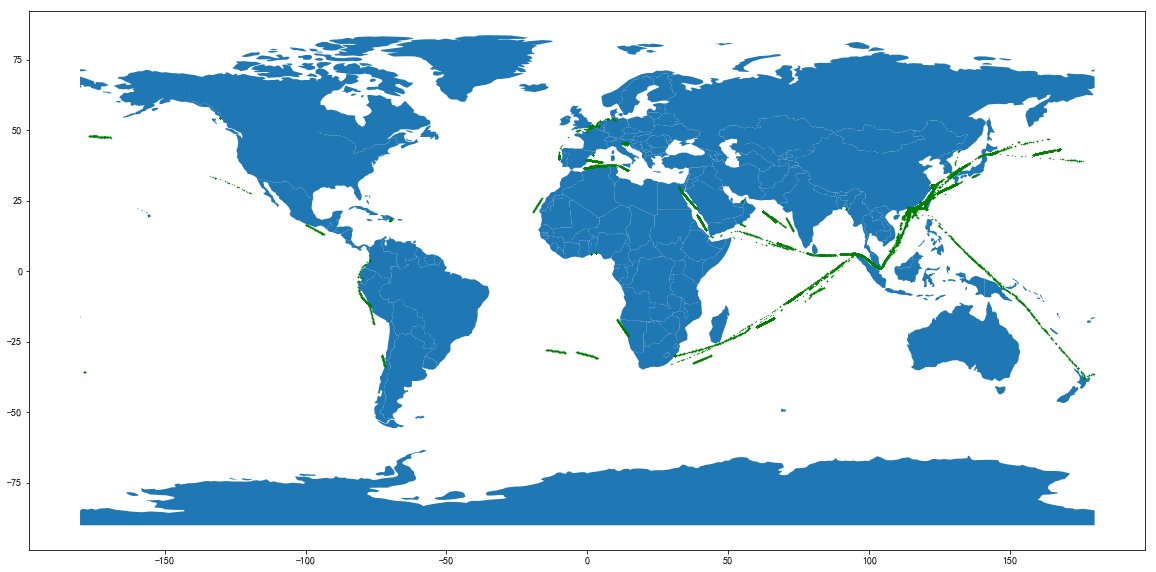

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig = plt.figure()
fig = world.plot(figsize = (20,10))
test_df = test_data[test_data['TRANSPORT_TRACE'] == course_list[1]]
fig.scatter(test_data['longitude'],test_data['latitude'],color = 'g',s=0.1)
fig.scatter(train_df['longitude'],train_df['latitude'],s=5,color = 'r')
fig.set_xlim([train_df['longitude'].min()-5,train_df['longitude'].max()+5])
fig.set_ylim([train_df['latitude'].min()-10,train_df['latitude'].max()+10])

In [16]:
course_list[1]

'BRSSZ-HKHKG'